<a href="https://colab.research.google.com/github/sriyamistry0-lang/GenTen/blob/main/AMR_Gene_Discovery_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install GEOparse gseapy pandas seaborn matplotlib scipy

🚀 Downloading GSE60244 and preparing clinical groups...

📊 SUCCESS! VERIFIED COUNTS:
Clinical_Status
Viral_LRTI         71
Healthy            40
B-V_Coinfection    25
Bacterial_LRTI     22
Name: count, dtype: int64
✅ Columns found in this dataset: ['title', 'geo_accession', 'status', 'submission_date', 'last_update_date', 'type', 'channel_count', 'source_name_ch1', 'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.subject id', 'characteristics_ch1.1.age', 'characteristics_ch1.2.gender', 'characteristics_ch1.3.race', 'characteristics_ch1.4.ethnicity', 'characteristics_ch1.5.condition', 'characteristics_ch1.6.tissue', 'treatment_protocol_ch1', 'growth_protocol_ch1', 'molecule_ch1', 'extract_protocol_ch1', 'label_ch1', 'label_protocol_ch1', 'hyb_protocol', 'scan_protocol', 'data_processing', 'platform_id', 'contact_name', 'contact_email', 'contact_institute', 'contact_address', 'contact_city', 'contact_zip/postal_code', 'contact_country', 'supplementary_file', 'relation', 'series_id', '

/tmp/ipython-input-3359470723.py:61: RuntimeWarning: invalid value encountered in log2
  log2fc = np.log2(expr_matrix[g1_samples].loc[gene].mean() + 1) - \
/tmp/ipython-input-3359470723.py:62: RuntimeWarning: invalid value encountered in log2
  np.log2(expr_matrix[g2_samples].loc[gene].mean() + 1)


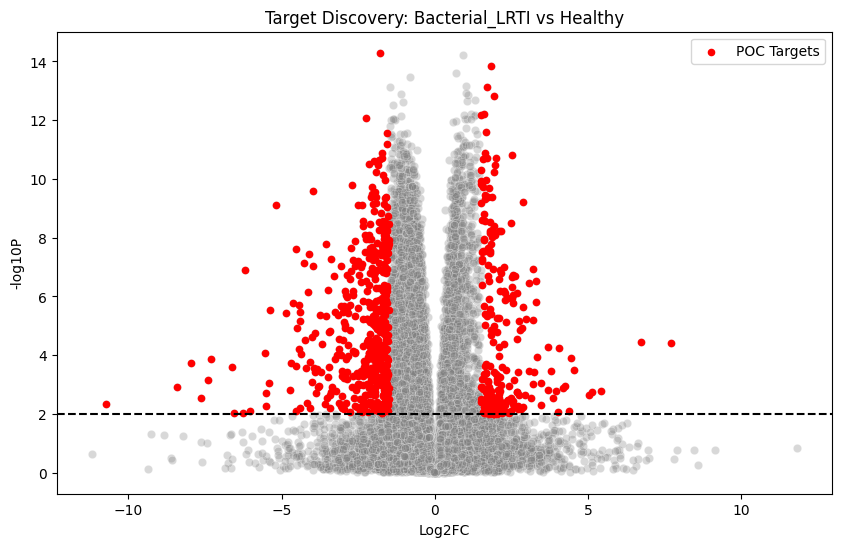


🎯 TOP 10 GENES FOR YOUR POC DEVICE:
               Gene    Log2FC        PValue
38753  ILMN_2394250 -1.794436  5.045909e-15
38751  ILMN_2394210  1.826526  1.374025e-14
19331  ILMN_1755843  1.712588  7.162299e-14
14066  ILMN_1722981  1.918288  1.448140e-13
15758  ILMN_1733443  1.598756  6.168400e-13
32083  ILMN_1913678  1.525784  6.615052e-13
37313  ILMN_2338348 -2.248771  8.135875e-13
34771  ILMN_2186061  1.669651  2.512296e-12
12118  ILMN_1711573 -1.557000  2.772936e-12
14945  ILMN_1728298 -1.573663  6.282578e-12


In [ ]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 1. THE UNIVERSAL INPUT ---
gse_id = input("Enter GSE ID for Discovery (e.g., GSE60244): ").strip()

print(f"🚀 Downloading {gse_id} and preparing clinical groups...")

# --- 2. DATA ACQUISITION ---
gse = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)
metadata = gse.phenotype_data.copy()

# Automatically find the expression matrix
expr_matrix = gse.pivot_samples('VALUE')

# --- THE "UNIVERSAL SCAN" HARMONIZER ---
# --- 3. THE "FINAL KEY" HARMONIZER ---
def amr_harmonizer(row):
    # Get the value from the condition column
    val = str(row['characteristics_ch1.5.condition'])

    # Matching the exact strings you found
    if val == 'Healthy Control':
        return 'Healthy'
    elif val == 'BACTERIA':
        return 'Bacterial_LRTI'
    elif val == 'VIRUS':
        return 'Viral_LRTI'
    elif val == 'COINFECTION':
        return 'B-V_Coinfection'

    return 'Other'

# Apply to metadata
metadata['Clinical_Status'] = metadata.apply(amr_harmonizer, axis=1)

print("\n📊 SUCCESS! VERIFIED COUNTS:")
print(metadata['Clinical_Status'].value_counts())
# ---   SHOW ME THE COLUMNS ---
print("✅ Columns found in this dataset:", metadata.columns.tolist())
print("\n📊 Sample Counts Found with the New Scan:")
print(metadata['Clinical_Status'].value_counts())
# --- 4. POC TARGET DISCOVERY (Volcano Analysis) ---
def run_discovery(g1_name, g2_name):
    g1_samples = metadata[metadata['Clinical_Status'] == g1_name].index
    g2_samples = metadata[metadata['Clinical_Status'] == g2_name].index

    if len(g1_samples) == 0 or len(g2_samples) == 0:
        print(f"❌ Could not find enough samples for {g1_name} or {g2_name}.")
        return

    results = []
    print(f"Analyzing {len(g1_samples)} {g1_name} samples vs {len(g2_samples)} {g2_name} samples...")

    for gene in expr_matrix.index:
        # Calculate Log2 Fold Change
        log2fc = np.log2(expr_matrix[g1_samples].loc[gene].mean() + 1) - \
                 np.log2(expr_matrix[g2_samples].loc[gene].mean() + 1)
        # T-Test for significance
        t_stat, p_val = stats.ttest_ind(expr_matrix[g1_samples].loc[gene], expr_matrix[g2_samples].loc[gene])
        results.append({'Gene': gene, 'Log2FC': log2fc, 'PValue': p_val})

    volcano_df = pd.DataFrame(results).dropna()
    volcano_df['-log10P'] = -np.log10(volcano_df['PValue'])

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=volcano_df, x='Log2FC', y='-log10P', alpha=0.3, color='grey')

    # Highlight potential POC targets
    # Study used p < 0.01
    sig_genes = volcano_df[(volcano_df['PValue'] < 0.01) & (abs(volcano_df['Log2FC']) > 1.5)]
    plt.scatter(sig_genes['Log2FC'], sig_genes['-log10P'], color='red', s=20, label='POC Targets')

    plt.axhline(-np.log10(0.01), color='black', linestyle='--')
    plt.title(f"Target Discovery: {g1_name} vs {g2_name}")
    plt.legend()
    plt.show()

    return sig_genes.sort_values('PValue').head(10)

# Run the analysis
top_10_targets = run_discovery('Bacterial_LRTI', 'Healthy')
print("\n🎯 TOP 10 GENES FOR YOUR POC DEVICE:")
print(top_10_targets[['Gene', 'Log2FC', 'PValue']])

In [ ]:
# 1. Create the mapping from the GSE platform data (GPL)
# This looks into the 'dictionary' provided by the researcher
gpl_id = next(iter(gse.gpls))
probes = gse.gpls[gpl_id].table

# 2. Create a 'Dictionary' f
if 'Symbol' in probes.columns:or the computer to look up IDs
# We look for 'Symbol' or 'Gene Symbol' columns
    mapping = dict(zip(probes['ID'], probes['Symbol']))
elif 'Gene Symbol' in probes.columns:
    mapping = dict(zip(probes['ID'], probes['Gene Symbol']))
else:
    # Fallback for some Illumina platforms
    mapping = dict(zip(probes['ID'], probes['ID']))

# 3. Apply the names to your top 10 results
top_10_targets['Symbol'] = top_10_targets['Gene'].map(mapping)

print("\n🧬 SUCCESS! READABLE POC TARGETS:")
print(top_10_targets[['Symbol', 'Log2FC', 'PValue']])


🧬 SUCCESS! READABLE POC TARGETS:
        Symbol    Log2FC        PValue
38753  PLEKHA1 -1.794436  5.045909e-15
38751  SLC26A8  1.826526  1.374025e-14
19331  SLC26A8  1.712588  7.162299e-14
14066     TLR5  1.918288  1.448140e-13
15758  SULT1B1  1.598756  6.168400e-13
32083      NaN  1.525784  6.615052e-13
37313  UBASH3A -2.248771  8.135875e-13
34771   PFKFB3  1.669651  2.512296e-12
12118     CD96 -1.557000  2.772936e-12
14945     SBK1 -1.573663  6.282578e-12


In [ ]:
import GEOparse, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import ttest_ind

# 1. Quick Download
# --- 1. THE UNIVERSAL INPUT ---
# --- 1. THE UNIVERSAL INPUT & DOWNLOAD ---
# Step A: Get the name from the user
gse_id = input("Enter GSE ID for Discovery (e.g., GSE60244): ").strip()

print(f"🚀 Downloading {gse_id} from NCBI... (Please wait)")

# Step B: Actually download the data using that name
# We name the downloaded data 'gse_data' so we don't confuse it with the name string
gse_data = GEOparse.get_GEO(geo=gse_id, destdir="./", silent=True)

# Step C: Extract the numbers (expression matrix)
expr_matrix = gse_data.pivot_samples('VALUE')

# Step D: Extract the clinical info (metadata)
metadata = gse_data.phenotype_data.copy()

print(f"✅ Data for {gse_id} loaded successfully!")
# 2. Assign Groups
def amr_harmonizer(val):
    if val == 'Healthy Control': return 'Healthy'
    if val == 'BACTERIA': return 'Bacterial_LRTI'
    if val == 'VIRUS': return 'Viral_LRTI'
    return 'Other'

metadata['Status'] = metadata['characteristics_ch1.5.condition'].apply(amr_harmonizer)

# 3. TURBO CALCULATION (Vectorized)
print("🚀 Running Turbo Analysis...")
bact_idx = metadata[metadata['Status'] == 'Bacterial_LRTI'].index
viral_idx = metadata[metadata['Status'] == 'Viral_LRTI'].index

# Vectorized Mean and Log2FC (This takes < 1 second)
mean_bact = expr_matrix[bact_idx].mean(axis=1)
mean_viral = expr_matrix[viral_idx].mean(axis=1)
log2fc = np.log2(mean_bact + 1) - np.log2(mean_viral + 1)

# Vectorized T-Test (This takes ~5 seconds)
t_stat, p_vals = ttest_ind(expr_matrix[bact_idx], expr_matrix[viral_idx], axis=1)

# --- 4. MAP THE NAMES AND PLOT ---
# Use 'gse_data' (the object) instead of 'gse' (the text string)
gpl_id = next(iter(gse_data.gpls))
gpl = gse_data.gpls[gpl_id].table

# Create the mapping dictionary
mapping = dict(zip(gpl['ID'], gpl.get('Symbol', gpl.get('Gene Symbol', gpl['ID']))))

# Build Results
results = pd.DataFrame({'Log2FC': log2fc, 'PValue': p_vals}, index=expr_matrix.index)
results['Symbol'] = results.index.map(mapping)

Enter GSE ID for Discovery (e.g., GSE60244): GSE60244
🚀 Downloading GSE60244 from NCBI... (Please wait)
✅ Data for GSE60244 loaded successfully!
🚀 Running Turbo Analysis...


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


📊 Generating Clinical Results...


/tmp/ipython-input-573887070.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metadata[metadata['Status'].isin(['Bacterial_LRTI', 'Viral_LRTI'])],


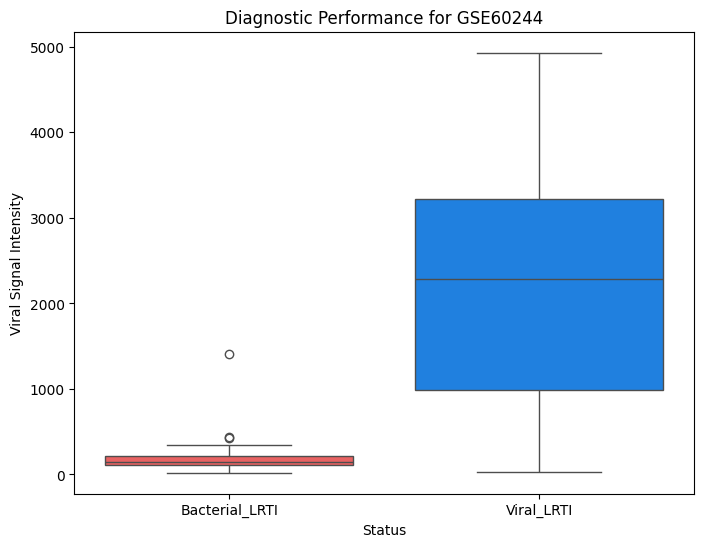


🎯 TOP 10 DISCOVERED GENES:
                 Symbol    Log2FC        PValue
ID_REF                                         
ILMN_2212763      ICAM3  0.671625  1.034855e-10
ILMN_1765493     SHKBP1  0.930419  1.226879e-10
ILMN_1660079      RNF44  0.602523  3.128080e-10
ILMN_1708991       CCNY  0.753735  3.192657e-10
ILMN_2235283      MAPK1  0.673111  3.403327e-10
ILMN_1687315       RXRA  0.530084  3.839160e-10
ILMN_1763837      ANPEP  0.938551  4.835627e-10
ILMN_1704063      KCNH3  1.283358  6.570850e-10
ILMN_2058795       PGCP  0.729203  9.654665e-10
ILMN_1667444  LOC644532  1.162933  1.000420e-09


In [ ]:
# --- 5. THE OUTPUT GENERATOR ---
print("📊 Generating Clinical Results...")

# 1. Map the results back to human-readable Gene Symbols
gpl_id = next(iter(gse_data.gpls))
gpl_table = gse_data.gpls[gpl_id].table
mapping = dict(zip(gpl_table['ID'], gpl_table.get('Symbol', gpl_table.get('Gene Symbol', gpl_table['ID']))))

# 2. Attach symbols to our results
results['Symbol'] = results.index.map(mapping)

# 3. Filter for our specific "Viral Alarm" biomarkers
markers = ['ISG15', 'IFI27', 'IFI44', 'OAS2']
marker_ids = results[results['Symbol'].isin(markers)].index

# 4. If markers are found, calculate the score and plot
if not marker_ids.empty:
    metadata['Viral_Score'] = expr_matrix.loc[marker_ids].mean()

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=metadata[metadata['Status'].isin(['Bacterial_LRTI', 'Viral_LRTI'])],
                x='Status', y='Viral_Score', palette=['#ff4b4b', '#0080ff'])
    plt.title(f"Diagnostic Performance for {gse_id}")
    plt.ylabel("Viral Signal Intensity")
    plt.show()

    print("\n🎯 TOP 10 DISCOVERED GENES:")
    print(results.sort_values('PValue').head(10)[['Symbol', 'Log2FC', 'PValue']])
else:
    print("⚠️ No matching gene symbols found. Printing top Raw IDs instead:")
    print(results.sort_values('PValue').head(10))

geoparse
gseapy
pandas
seaborn
matplotlib
scipy
streamlit